In [14]:
from openparticle import ParticleOperator
from openparticle.utils import get_fock_basis, generate_matrix
from openparticle.hamiltonians.phi4_hamiltonian import phi4_Hamiltonian
import cirq
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))

from src.lobe.system import System
from src.lobe.lcu import LCU
from src.lobe.lobe_circuit import lobe_circuit
from src.lobe.block_encoding import add_lobe_oracle
from cirq.contrib.svg import SVGCircuit
from src.lobe.usp import add_naive_usp
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.rescale import bosonically_rescale_terms, rescale_terms_usp, get_numbers_of_bosonic_operators_in_terms, get_number_of_active_bosonic_modes,get_active_bosonic_modes
from src.lobe._utils import get_basis_of_full_system, get_bosonic_exponents, pretty_print
from src.lobe.index import index_over_terms
from src.lobe.metrics import CircuitMetrics
from src.lobe.bosonic import bosonic_product_plus_hc_block_encoding, bosonic_modes_block_encoding

from colors import *

In [74]:
def check_unitary(operator, circuit, resolution, max_bosonic_occupancy, system, rescaling_factor):
    if len(circuit.all_qubits()) > 18:
        print("Skipped: ", len(circuit.all_qubits()))
    
    full_fock_basis = get_fock_basis(operator, max_bosonic_occupancy)
    expected_unitary = generate_matrix(operator, full_fock_basis)
    
    if len(circuit.all_qubits()) <= 12:
        print("Checking Unitary: ", resolution)
        rescaled_block = circuit.unitary()[:1 << system.number_of_system_qubits, :1 << system.number_of_system_qubits]*rescaling_factor
        if not np.allclose(rescaled_block, expected_unitary):
            print(circuit)
            print(rescaled_block.real.round(2))
            print(expected_unitary.real.round(2))
            assert False
        print("Passed")
    # else:
    #     print(
    #         f"Testing singular quantum state for circuit with {len(circuit.all_qubits())} qubits"
    #     )
    #     simulator = cirq.Simulator()

    #     zero_state = np.zeros(
    #         1 << (
    #             len(circuit.all_qubits())
    #             - system.number_of_system_qubits
    #             - 1
    #         ), dtype=complex,
    #     )
    #     zero_state[0] = 1

    #     initial_control_state = [1, 0]

    #     random_system_state = np.zeros(1 << system.number_of_system_qubits)
    #     while np.isclose(np.linalg.norm(expected_unitary @ random_system_state), 0):
    #         random_system_state = 1j * np.random.uniform(
    #             -1, 1, 1 << system.number_of_system_qubits
    #         )
    #         random_system_state += np.random.uniform(
    #             -1, 1, 1 << system.number_of_system_qubits
    #         )
    #         random_system_state = random_system_state / np.linalg.norm(
    #             random_system_state
    #         )

    #     initial_state = np.kron(np.kron(zero_state, initial_control_state), random_system_state)

    #     output_state = simulator.simulate(
    #         circuit, initial_state=initial_state
    #     ).final_state_vector
    #     final_state = output_state[: 1 << system.number_of_system_qubits]

    #     expected_final_state = expected_unitary @ random_system_state
    #     expected_final_state = expected_final_state / np.linalg.norm(
    #         expected_final_state
    #     )
    #     normalized_final_state = final_state/ np.linalg.norm(final_state)
    #     if not np.allclose(expected_final_state, normalized_final_state, atol=1e-4):
    #         print(pretty_print(random_system_state, [system.number_of_system_qubits]))
    #         print("Failed")
    #         print(expected_unitary.real.round(2))
    #         print(pretty_print(expected_final_state, [system.number_of_system_qubits]))
    #         print(pretty_print(normalized_final_state, [system.number_of_system_qubits]))
    #         assert False
    #     print("Passed")

In [75]:
def phi4_lcu_circuit_metrics(resolution, max_bose_occ):
    operator = operator = phi4_Hamiltonian(resolution, g = 1, mb = 1)
    operator.remove_identity()

    lcu = LCU(operator, max_bosonic_occupancy=max_bose_occ, zero_threshold=1e-6)

    circuit = lcu.get_circuit()
    full_fock_basis = get_fock_basis(operator, max_bose_occ=max_bose_occ)
    expected_unitary = generate_matrix(operator, full_fock_basis)
    
    system = System(operator.max_bosonic_mode + 1, max_bose_occ, 1000, False, False, True)
    check_unitary(operator=operator, circuit=circuit, resolution = resolution, max_bosonic_occupancy=max_bose_occ, system = system, rescaling_factor=lcu.one_norm)
    return lcu.circuit_metrics, lcu.one_norm, len(lcu.index_register)

In [76]:
def phi4_lobe_circuit_metrics(resolution, max_bose_occ):
    operator = phi4_Hamiltonian(resolution, g = 1, mb = 1)
    groups = operator.group()
    max_number_of_active_modes = max(get_number_of_active_bosonic_modes(groups))
    
    number_of_block_encoding_anillae = 1 + int(np.ceil(np.log2(len(groups)))) + max_number_of_active_modes
    index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(groups)))))]
    block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_block_encoding_anillae)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    system = System(operator.max_bosonic_mode + 1, max_bose_occ, 1000, False, False, True)

    block_encoding_functions = []
    rescaling_factors = []
    
    for term in groups:
        plus_hc = False
        if len(term) == 2:
            plus_hc = True
            term = term.to_list()[0]
        active_modes, exponents = get_bosonic_exponents(term, 
                                operator.max_bosonic_mode + 1)

        if not plus_hc:
            block_encoding_functions.append(partial(
                bosonic_modes_block_encoding,
                system=system,
                block_encoding_ancillae=block_encoding_ancillae,
                active_indices=active_modes,
                exponents_list=exponents,
                clean_ancillae=clean_ancillae[1:]
            ))
            rescaling_factors.append(np.sqrt(max_bose_occ)**(sum(sum(np.asarray(exponents)))))
        else:
            block_encoding_functions.append(partial(
                bosonic_product_plus_hc_block_encoding,
                system=system,
                block_encoding_ancillae=block_encoding_ancillae,
                active_indices=active_modes,
                exponents_list=exponents,
                clean_ancillae=clean_ancillae[1:]
            ))
            rescaling_factors.append(2*np.sqrt(max_bose_occ)**(sum(sum(np.asarray(exponents)))))



    rescaled_coefficients = []
    for term, rescaling_factor in zip(groups, rescaling_factors):
        rescaled_coefficients.append(term.coeffs[0] * rescaling_factor / max(rescaling_factors))

    target_state = get_target_state(rescaled_coefficients)
    gates = []
    metrics = CircuitMetrics()

    gates.append(cirq.X.on(ctrls[0][0]))

    _gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    gates.append(cirq.X.on(ctrls[0][0]))

    overall_rescaling_factor = sum([term.coeffs[0]*rescaling_factor for term, rescaling_factor in zip(groups, rescaling_factors)])
    circuit = cirq.Circuit(gates)
    check_unitary(operator, circuit, resolution, max_bose_occ, system, overall_rescaling_factor)

    return  metrics, overall_rescaling_factor, len(index_register) + number_of_block_encoding_anillae

            

In [77]:
def _get_phi4_hamiltonian_norm(res, max_bose_occ, g=1):
    ham = phi4_Hamiltonian(res, g = g, mb = 1)
    basis = get_fock_basis(ham, max_bose_occ)
    matrix = generate_matrix(ham, basis)


    vals = np.linalg.eigvalsh(matrix)
    return max(np.abs(vals))

In [81]:
omega = 3
resolutions = np.arange(2, 8, 1)
print("LOBE")

GROUPED_LOBE_DATA = [phi4_lobe_circuit_metrics(res, omega) for res in resolutions]
print("LCU")
LCU_DATA = [phi4_lcu_circuit_metrics(res, omega) for res in resolutions]

operator_norms = []
for res in resolutions:
    operator = phi4_Hamiltonian(res, 1, 1).normal_order()
    operator.remove_identity()
    operator_norms.append(_get_phi4_hamiltonian_norm(res, omega))
    print(res, operator_norms[-1])
system_qubits = [System(phi4_Hamiltonian(res, 1, 1).max_bosonic_mode, omega, 1000, False, False, True).number_of_system_qubits for res in resolutions]

LOBE
Skipped:  19
Skipped:  23
Skipped:  26
Skipped:  28
Skipped:  31


KeyboardInterrupt: 

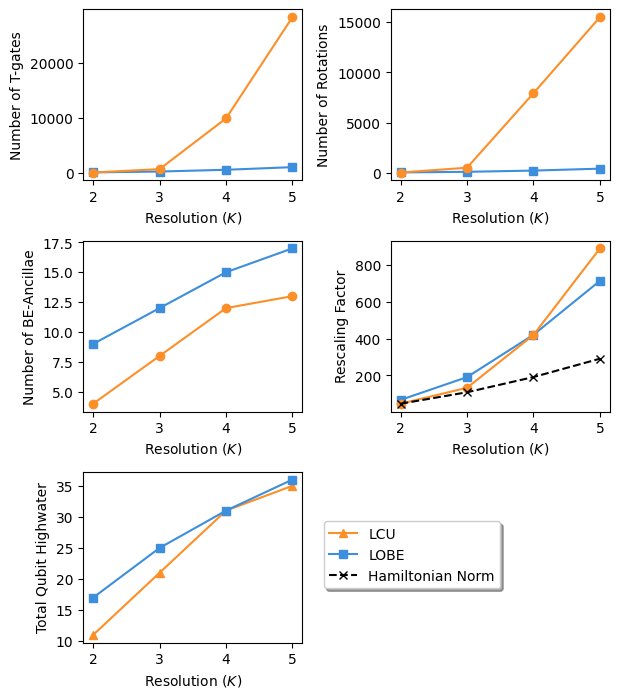

In [80]:
fig, axes = plt.subplots(3, 2, figsize=(16 / 2.54, 18 / 2.54))

axes[0][0].plot(resolutions, [4 * GROUPED_LOBE_DATA[i][0].number_of_elbows for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 1, label = 'LOBE')
axes[0][0].plot(resolutions, [4 * LCU_DATA[i][0].number_of_elbows for i in range(len(resolutions))], color=ORANGE, marker='o', alpha = 1, label = 'LCU')
axes[0][0].set_ylabel("Number of T-gates")
axes[0][0].set_xlabel("Resolution $(K$)")

axes[0][1].plot(resolutions, [GROUPED_LOBE_DATA[i][0].number_of_rotations for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 1, label = 'LOBE')
axes[0][1].plot(resolutions, [LCU_DATA[i][0].number_of_rotations for i in range(len(resolutions))], color=ORANGE, marker='o', alpha = 1, label = 'LCU')
axes[0][1].set_ylabel("Number of Rotations")
axes[0][1].set_xlabel("Resolution $(K$)")

axes[1][0].plot(resolutions, [GROUPED_LOBE_DATA[i][2] for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 1, label = 'LOBE')
axes[1][0].plot(resolutions, [LCU_DATA[i][2] for i in range(len(resolutions))], color=ORANGE, marker='o', alpha = 1, label = 'LCU')
axes[1][0].set_ylabel("Number of BE-Ancillae")
axes[1][0].set_xlabel("Resolution $(K$)")

axes[1][1].plot(resolutions, [GROUPED_LOBE_DATA[i][1] for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 1, label = 'LOBE')
axes[1][1].plot(resolutions, [LCU_DATA[i][1] for i in range(len(resolutions))], color=ORANGE, marker='o', alpha = 1, label = 'LCU')
axes[1][1].plot(resolutions, [operator_norms[i] for i in range(len(resolutions))], color="black", marker='x', ls='--', alpha = 1)
axes[1][1].set_ylabel("Rescaling Factor")
axes[1][1].set_xlabel("Resolution $(K$)")


axes[2][0].plot(resolutions, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + system_qubits[i] + 1 for i in range(len(resolutions))], color=ORANGE, marker='^', alpha = 1, label="LCU")
axes[2][0].plot(resolutions, [GROUPED_LOBE_DATA[i][0].ancillae_highwater() + GROUPED_LOBE_DATA[i][2] + system_qubits[i] + 1 for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 1, label="LOBE")
axes[2][0].plot([], [], color="black", marker='x', ls='--', alpha = 1, label="Hamiltonian Norm")
axes[2][0].set_ylabel("Total Qubit Highwater")
axes[2][0].set_xlabel("Resolution ($K$)")

fig.delaxes(axes[2][1])
plt.tight_layout()
axes[2][0].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
          fancybox=True, shadow=True, ncol=1)
plt.savefig("../manuscript/figures/phi4_resolution_scaling.pdf", dpi=300)

In [ ]:
op = ParticleOperator('a1^ a0 a0')
active_indices = [0, 1]
exponents = [(0, 2), (1, 0)]

max_bose_occ = 3
terms = op.to_list()

bosonically_rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(terms, max_bose_occ)
coefficients = [term.coeff for term in bosonically_rescaled_terms]

norm = sum(np.abs(coefficients))
target_state = get_target_state(coefficients)
asp_rescaling_factor = (bosonic_rescaling_factor * norm)

number_of_modes = max([term.max_mode for term in terms]) + 1

number_of_ancillae = (
    1000  # Some arbitrary large number with most ancilla disregarded
)
number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
number_of_rotation_qubits = len(active_indices)

# Declare Qubits
control = cirq.LineQubit(0)
clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]

block_encoding_ancillae = [
    cirq.LineQubit(number_of_index_qubits + i + number_of_ancillae)
    for i in range(number_of_rotation_qubits + 1)
] #Index register + rotation qubits

system = System(
    number_of_modes=number_of_modes,
    maximum_occupation_number=max_bose_occ,
    number_of_used_qubits=1
    + number_of_ancillae
    + number_of_rotation_qubits
    + number_of_index_qubits,
    has_fermions=op.has_fermions,
    has_antifermions=op.has_antifermions,
    has_bosons=op.has_bosons,
)
gates = []
gates.append(cirq.X.on(control))
_gates, metrics = bosonic_product_plus_hc_block_encoding(
    system,
    block_encoding_ancillae,
    active_indices,
    exponents,
    clean_ancillae=clean_ancillae,
    ctrls = ([control], [1])
)
gates += _gates
gates.append(cirq.X.on(control))

Block encoding
 1.0 * a1^ a0 a0
1.0 * a0^ a0^ a1



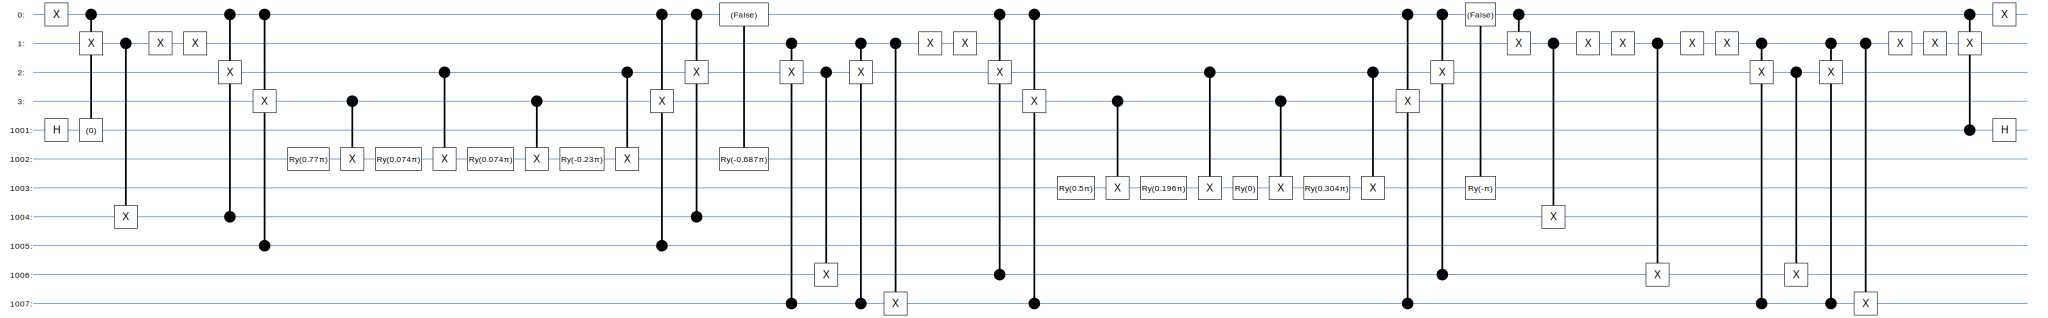

In [ ]:
print("Block encoding\n", op + op.dagger())
SVGCircuit(cirq.Circuit(gates))

In [ ]:
unitary_rescaling_factor = 2 * np.sqrt(max_bose_occ)**sum(sum(np.asarray(exponents)))

unitary = cirq.Circuit(gates).unitary()[
    :1<<system.number_of_system_qubits, :1<<system.number_of_system_qubits
] * unitary_rescaling_factor

In [ ]:
# basis = get_fock_basis(op + op.dagger(), max_bose_occ=max_bose_occ)
basis = get_basis_of_full_system(2, max_bose_occ, False, False, True)
matrix = generate_matrix(op + op.dagger(), basis)

In [ ]:
np.allclose(unitary, matrix)

True

In [ ]:
get_active_bosonic_modes(terms[0])

[1, 0]

In [ ]:
get_number_of_active_bosonic_modes(terms)

[2]